# Forecasting Usage of New York City's 311 Service  
New York City maintains an information and reporting service for city residents that permit them to source information from and report problems to City Government with greater ease.  While the service is an important enhancement to resident life, it imposes an administrative burden on the City as it must receive the requests and reports and refer them to the correct City agency.  A model that can accurately forecast usage of the service would allow the City to serve residents more efficiently.  
<br>
This analysis will search for a model with stronger predictive power than a baseline model.  Potential models will include:
- ARIMA of varying orders
- SARIMA (ARIMA with seasonality) of varying orders
- SARIMAX (SARIMA with exogenous variables) with various regressors
- Prophet, a newer and more flexible model with better handling of seasonality
- GARCH and GARCH-X, if heteroskedasticity is an issue
- Neural networks (LSTM)

In [23]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter
import seaborn as sns
from cycler import cycler

from dask import delayed, compute
from dask.distributed import Client, as_completed
import gc
import itertools
from typing import Optional, Tuple, List, Union
import time

# Modeling
from arch import arch_model

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df

from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, Dropout, Flatten, GRU, Input, LSTM, MaxPooling1D 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [79]:
# Change formatting for images
%matplotlib inline

font_path = r'C:\Windows\Fonts\GIL_____.ttf'
fm.fontManager.addfont(font_path)
custom_font = fm.FontProperties(fname=font_path).get_name()

plt.rcParams['axes.prop_cycle'] = cycler(color=['#6C5B7B'])
background_color = (240/255, 240/255, 240/255)
plt.rcParams['figure.facecolor'] = background_color
plt.rcParams['axes.facecolor'] = background_color
plt.rcParams['font.family'] = custom_font

In [3]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 100)

## Data Preparation
The data sources are:  
- NYC OpenData's 311 call database, which includes calls dating from January 1, 2010
- Daily weather for New York City, retrieved from OpenMeteo's API

To simplify the functioning of this notebook, the data has been processed and stored in pickle files.  To learn more about how, view the notebook titled 'NYC_311_Data_Prep.ipynb' in the Notebooks subfolder.

In [4]:
# Read in prepared data
df_311_calls = pd.read_pickle('Data/311_Calls.pickle')
df_zips = pd.read_pickle('Data/NYC_Zips.pickle')
df_weather = pd.read_pickle('Data/NYC_Weather.pickle')

#### Visualize Distributions

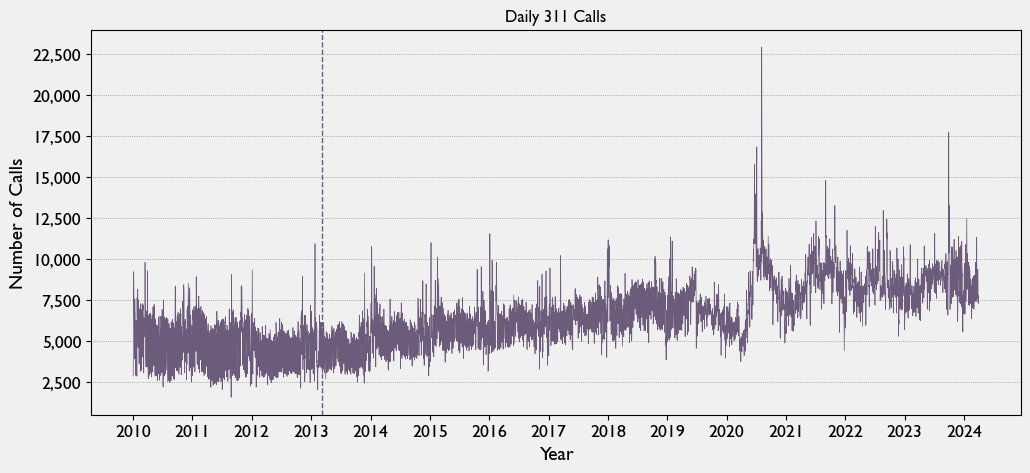

In [80]:
daily_plot = df_311_calls.groupby('Date').size()
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(daily_plot, linewidth=.5)
ax.set_xlabel('Year', fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=13)
ax.set_ylabel('Number of Calls', fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=13)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.yaxis.set_major_locator(MultipleLocator(2500))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))

ax.grid(which='major', axis='y', linestyle=':', linewidth=0.5, color='gray')
ax.axvline(pd.to_datetime('2013-03-09'), linestyle='--', linewidth=1)
output_file = 'Charts/daily_call_volume.jpg'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
ax.set_title('Daily 311 Calls')
plt.show()

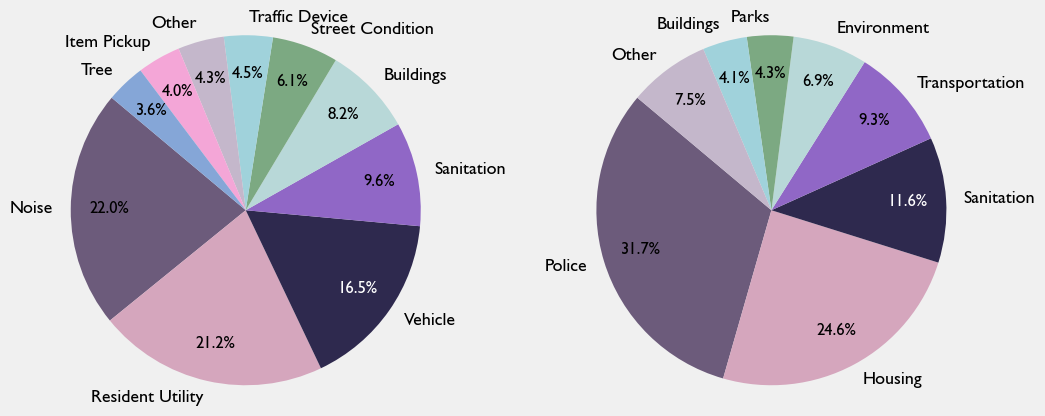

In [81]:
types = df_311_calls.groupby('Type', observed=True).size().sort_values(ascending=False)[:10]
labels = types.index.to_list()
sizes = types.values
colors = ['#6C5B7B', '#D5A6BD', '#2E294E', '#9067C6', '#B8D8D8',
          '#7CA982', '#A0D2DB', '#C4B7CB', '#F4A6D7', '#85A6D7']

agencies = df_311_calls.groupby('Agency', observed=True).size().sort_values(ascending=False)[:7]
other_size = df_311_calls.groupby('Agency', observed=True).size().sort_values(ascending=False)[7:].sum()
labels2 = agencies.index.to_list() + ['Other']
sizes2 = list(agencies.values) + [other_size]
colors2 = ['#6C5B7B', '#D5A6BD', '#2E294E', '#9067C6', '#B8D8D8',
          '#7CA982', '#A0D2DB', '#C4B7CB']

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
wedges1, texts1, autotexts1 = ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')
wedges2, texts2, autotexts2 = ax2.pie(sizes2, labels=labels2, colors=colors2, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')

for text in texts1 + texts2:
    text.set_fontsize(13)

for autotext in autotexts1 + autotexts2:
    autotext.set_fontsize(12)
    x, y = autotext.get_position()
    autotext.set_position((x * 1.3, y * 1.3))

autotexts1[2].set_color('white')
autotexts2[2].set_color('white')

plt.subplots_adjust(wspace=0.3)

output_file = 'Charts/distro_by_agency_and_type.jpg'
plt.savefig(output_file, dpi=300, bbox_inches='tight')

plt.show()

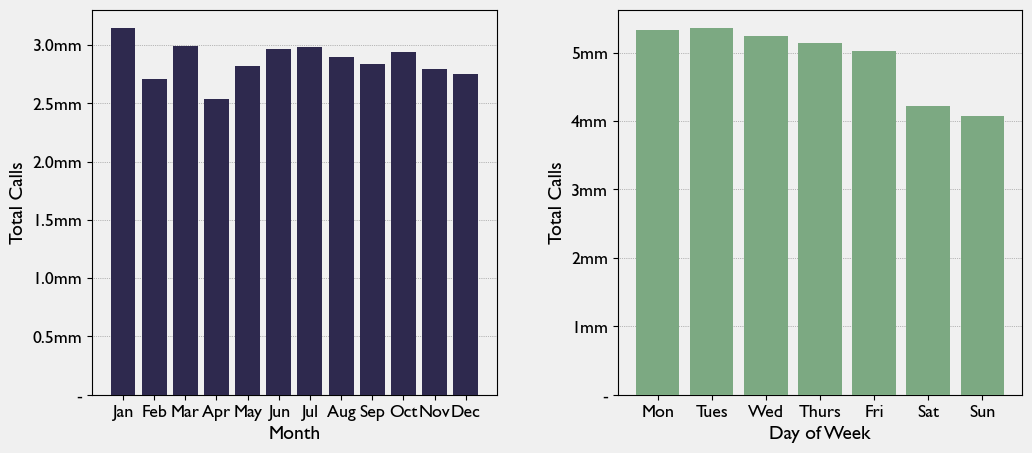

In [88]:
months = df_311_calls['Date'].dt.month.value_counts()
day_week = df_311_calls['Date'].dt.day_of_week.value_counts() 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.bar(x=months.index, height=months, color='#2E294E', zorder=3)
ax2.bar(x=day_week.index, height=day_week, color='#7CA982', zorder=3)
plt.subplots_adjust(wspace=0.3)

x1_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y1_labels = ['-', '0.5mm', '1.0mm', '1.5mm', '2.0mm', '2.5mm', '3.0mm']
x2_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
y2_labels = ['-', '1mm', '2mm', '3mm', '4mm', '5mm']

ax1.set_xlabel('Month', fontsize=14)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(x1_labels, fontsize=13)
ax1.set_ylabel('Total Calls', fontsize=14)
ax1.set_yticks(range(0, 3500000, 500000))
ax1.set_yticklabels(y1_labels, fontsize=13)
ax1.grid(which='major', axis='y', linestyle=':', linewidth=0.5, color='gray', zorder=0)

ax2.set_xlabel('Day of Week', fontsize=14)
ax2.set_xticks(range(7))
ax2.set_xticklabels(x2_labels, fontsize=13)
ax2.set_ylabel('Total Calls', fontsize=14)
ax2.set_yticks(range(0, 6000000, 1000000))
ax2.set_yticklabels(y2_labels, fontsize=13)
ax2.grid(which='major', axis='y', linestyle=':', linewidth=0.5, color='gray', zorder=0)

output_file = 'Charts/calls_by_month_and_day_of_week.jpg'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

### Weather

In [ ]:
# Visualize weather data
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle('Weather Histograms')

ax1.hist(df_weather['temperature_2m_max'].value_counts().index, bins=100)
ax1.set_xlabel('Max Daily Temp (F)')
ax2.hist(df_weather['temperature_2m_min'].value_counts().index, bins=100)
ax2.set_xlabel('Min Daily Temp (F)')
ax3.hist(df_weather['temperature_2m_mean'].value_counts().index, bins=100)
ax3.set_xlabel('Avg Daily Temp (F)')
ax4.hist(df_weather['daylight_duration'].value_counts().index, bins=100)
ax4.set_xlabel('Daylight Duration (seconds)')
ax5.hist(df_weather['rain_sum'].value_counts().index, bins=100)
ax5.set_xlabel('Rainfall (inches)')
ax6.hist(df_weather['snowfall_sum'].value_counts().index, bins=100)
ax6.set_xlabel('Snowfall (inches)')
ax7.hist(df_weather['wind_speed_10m_max'].value_counts().index, bins=100)
ax7.set_xlabel('Wind Speed (mph)')
ax8.axis('off')
plt.tight_layout(pad=2.0)
plt.show;

#### Scaling
- Rainfall, snowfall and wind speed: Box-Cox transformation, addresses right-skewed distributions
- Temperatures - Temperatures are normally distributed when holding seasonality constant.  Seasonal decompose first, then standard scale, then seasonal recompose
- Daylight Duration - Minmax scaling

In [ ]:
# Scaling functions for weather data

# log transform with a small constant
def log_transform(series, constant=1e-6):
    return np.log(series + constant)

# Helper function to apply Box-Cox transformation
def boxcox_transform(series):
    series_nonzero = series + 1e-6  # Add small constant to avoid zero values
    transformed_data, _ = boxcox(series_nonzero)
    return pd.Series(transformed_data, index=series.index)

# Seasonal decompose and recompose function
def decompose_and_scale(series, period=365):
    series = series.dropna()  # Drop NaNs if any
    decomposition = seasonal_decompose(series, model='additive', period=period)
    seasonal = decomposition.seasonal
    adjusted_series = series - seasonal  # Adjust the original series by removing the seasonal component

    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(adjusted_series.values.reshape(-1, 1))

    scaled_series_full = pd.Series(scaled_series.flatten(), index=adjusted_series.index)
    scaled_series_full = scaled_series_full.reindex(series.index).bfill().ffill()

    return scaled_series_full


In [ ]:
# Applying transformations

# Temperature columns: seasonal decompose, scale, recompose
df_weather['temperature_2m_max_scaled'] = decompose_and_scale(df_weather['temperature_2m_max'])
df_weather['temperature_2m_min_scaled'] = decompose_and_scale(df_weather['temperature_2m_min'])
df_weather['temperature_2m_mean_scaled'] = decompose_and_scale(df_weather['temperature_2m_mean'])

# Daylight duration: MinMax scale
df_weather['daylight_duration_scaled'] = MinMaxScaler().fit_transform(df_weather['daylight_duration'].values.reshape(-1, 1))

# Rainfall and Snowfall: Log transform with small constant
df_weather['rain_sum_log'] = boxcox_transform(df_weather['rain_sum'])
df_weather['snowfall_sum_log'] = boxcox_transform(df_weather['snowfall_sum'])

# Wind speed: Log transform
df_weather['wind_speed_10m_max_log'] = boxcox_transform(df_weather['wind_speed_10m_max'])

df_weather.drop(columns=['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
                         'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max'], inplace=True)

df_weather.rename(columns={
    'temperature_2m_max_scaled': 'temperature_2m_max',
    'temperature_2m_min_scaled': 'temperature_2m_min',
    'temperature_2m_mean_scaled': 'temperature_2m_mean',
    'daylight_duration_scaled': 'daylight_duration',
    'rain_sum_log': 'rain_sum',
    'snowfall_sum_log': 'snowfall_sum',
    'wind_speed_10m_max_log': 'wind_speed_10m_max'
}, inplace=True)

## Modeling
- Perform Baseline model, 1 day shift (equal to ARIMA(0,1,0))
- Step up to ARIMA model to see if performance can be improved
- Search for seasonality (weekly and annually) and apply SARIMA if found
- SARIMA can only handle one dimension of seasonality, consider TBATs for more than one period
  

In [ ]:
# Identify future target columns
target_cols = ['Agency', 'Type', 'Zip', 'Borough']

# Create Master dataset to use for modeling
df_311_dates_drop = df_311_calls.drop(columns=target_cols, axis=1)
time_series = df_311_dates_drop.groupby('Date').size().reset_index(name='Count')
time_series.set_index('Date', inplace=True)

# Dummy for COVID period
lockdown1 = pd.date_range(start='2020-03-21', end='2020-06-06', inclusive='both')
lockdown2 = pd.date_range(start='2021-07-09', end='2021-10-27', inclusive='both')
lockdown3 = pd.date_range(start='2021-02-13', end='2021-02-17', inclusive='both')
lockdown4 = pd.date_range(start='2021-05-28', end='2021-06-10', inclusive='both')
lockdowns = lockdown1.union(lockdown2).union(lockdown3).union(lockdown4)

time_series['covid'] = time_series.index.isin(lockdowns) * 1
time_series['winter'] = (time_series.index.month <= 2) * 1
time_series['weekend'] = (time_series.index.dayofweek >= 5) * 1
time_series['311_app'] = (time_series.index >= pd.Timestamp('2013-03-19')) * 1

time_series = pd.concat([time_series, df_weather], axis=1)

In [ ]:
# Interpolate NYC population using US Census estimates
population_data = {
    'date': pd.to_datetime(['2010-01-01', '2010-07-01', '2011-07-01', '2012-07-01', '2013-07-01', '2014-07-01',
                            '2015-07-01', '2016-07-01', '2017-07-01', '2018-07-01', '2019-07-01',
                            '2020-04-01', '2020-07-01', '2021-07-01', '2022-07-01', '2023-07-01', '2024-03-31']),
    'population': [8175133, 8190209, 8251281, 8312676, 8374527, 8436839, 8499614, 8562857, 8626570, 8690757, 8755421, 8804199, 8740292, 8462216, 8335798, 8258035, 8200257]
}

# Create DataFrame
population_df = pd.DataFrame(population_data)

# Set the date as index
population_df.set_index('date', inplace=True)

# Generate a date range from 2010-01-01 to 2024-03-31
date_range = pd.date_range(start='2010-01-01', end='2024-03-31', freq='D')

# Reindex the population data to the full date range, using interpolation to fill in the gaps
population_daily_df = population_df.reindex(date_range)
population_daily_df['population'] = population_daily_df['population'].interpolate(method='linear')

# Scale population numbers
population_daily_df['population'] = MinMaxScaler().fit_transform(population_daily_df['population'].values.reshape(-1, 1))

time_series = pd.concat([time_series, population_daily_df], axis=1)
time_series = time_series.asfreq('D')

In [ ]:
test_size = 731         # two years plus one day

split_point = len(time_series) - test_size
train_df = time_series.iloc[:split_point]
test_df = time_series.iloc[split_point:]

<br>

***Rolling Forecast function***: There is no native function to perform a rolling forecast over a time series.  Because this notebook will perform rolling forecasts repeatedly, a helper function will help to make the notebook more readable, and to avoid repetition.  The function will be applicable to any ARIMA or SARIMA forecasts.  It will always need testing and training sets and a pdq tuple as arguments.  For SARIMA models, it will also need a PDQm tuple.  For SARIMAX models, it will also need exogenous training and testing sets.  The function assumes a maximum of 50 iterations, but can be reset higher by keyword argument.  The function returns MAPE, training predictions and future predictions, and optionally, the last model object for reporting purposes.  
<br>
***Plot Forecast function***: The forecast will be plotted repeatedly.  This function makes the notebook more readable and allows parameters to be changed one time to apply to all charts

In [ ]:
def rolling_forecast(train_series: pd.Series,
                     test_series: pd.Series,
                     pdq: Tuple[int, int, int],
                     seasonal_pdq: Optional[Tuple[int, int, int, int]] = None,
                     exog_train: Optional[pd.DataFrame] = None,
                     exog_test: Optional[pd.DataFrame] = None,
                     maxiter: int = 50,
                     return_last_model: bool = False,
                     start_params: Optional[List[float]] = None) -> Union[Tuple[float, pd.Series, List[float]], Tuple[float, pd.Series, List[float], SARIMAX]]:

    history = list(train_series)
    exog_history = exog_train.values.tolist() if exog_train is not None else None
    predictions = []
    total_steps = len(test_series)
    start_time = time.time()

    train_pred = None
    
    for t in range(total_steps):
        if exog_history is not None:
            model = SARIMAX(history, exog=exog_history, order=pdq, seasonal_order=seasonal_pdq)
            model_fit = model.fit(disp=False, maxiter=maxiter, start_params=start_params)
            yhat = model_fit.forecast(exog=exog_test.iloc[t:t+1])[0]
            exog_history.append(exog_test.iloc[t].values)
            if t == 0:
                train_pred = model_fit.predict(start=0, end=len(train_series) - 1, exog=exog_train)
        else:
            model = SARIMAX(history, order=pdq, seasonal_order=seasonal_pdq)
            model_fit = model.fit(disp=False, maxiter=maxiter, start_params=start_params)
            yhat = model_fit.forecast()[0]
            if t == 0:
                train_pred = model_fit.predict(start=0, end=len(train_series) - 1)
        predictions.append(yhat)
        history.append(test_series.iloc[t])

        # Do not grow the training size!
        if len(history) > len(train_series):
            history.pop(0)
            if exog_history is not None:
                exog_history.pop(0)

        gc.collect()

        if (t + 1) % 100 == 0 or (t + 1) == total_steps:
            elapsed_time = time.time() - start_time
            print(f"Progress: {t + 1} out of {total_steps} steps completed in {elapsed_time} seconds")
            start_time = time.time()

    mape = mean_absolute_percentage_error(test_series, predictions)

    if return_last_model:
        return mape, train_pred, predictions, model_fit
    return mape, train_pred, predictions

In [ ]:
def plot_forecast(train_series: pd.Series,
                  test_series: pd.Series,
                  train_pred: pd.Series,
                  test_pred: list,
                  title: str) -> None:
    fig, ax = plt.subplots(figsize=(13, 3))
    ax.plot(train_series.index, train_pred, label='Training Prediction', color='blue', alpha=0.6)
    ax.plot(test_series.index, test_pred, label='Test Prediction', color='orange', alpha=0.6)
    ax.scatter(train_series.index, train_series,
               alpha=0.3, label='Training Data', color='blue', edgecolors='black', linewidths=.5, s=10)
    ax.scatter(test_series.index, test_series,
               alpha=0.3, label='Testing Data', color='orange', edgecolors='black', linewidths=.5, s=10)

    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title(f'{title}')
    plt.legend()
    plt.show()

### Choosing a Baseline Model
Three different models could serve as a baseline for a time series problem.  Each is assessed below:
- First order regressive, or AR(1)
- Random walk
- First order moving average, or MA(1)  

##### AR(1) Model

In [ ]:
# ARIMA (1, 0, 0)
arima_100_mape, arima_100_train_pred, arima_100_predictions, arima_100_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                (1, 0, 0), return_last_model=True)
print(f'MAPE: {arima_100_mape:.4f}')

In [ ]:
arima_100_model.summary()

In [ ]:
plot_forecast(train_df['Count'], test_df['Count'], arima_100_train_pred, arima_100_predictions, "ARIMA (1,0,0)")

##### Random Walk

In [ ]:
%%time
# ARIMA (0, 1, 0)
arima_010_mape, arima_010_train_pred, arima_010_predictions, arima_010_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                (0, 1, 0), return_last_model=True)
print(f'MAPE: {arima_010_mape:.4f}')

In [ ]:
arima_010_model.summary()

In [ ]:
plot_forecast(train_df['Count'], test_df['Count'], arima_010_train_pred, arima_010_predictions, "ARIMA (0, 1, 0)")

<br>

##### MA(1) Model

In [ ]:
%%time
# ARIMA (0, 0, 1)
arima_001_mape, arima_001_train_pred, arima_001_predictions, arima_001_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                (0, 0, 1), return_last_model=True)
print(f'MAPE: {arima_001_mape:.4f}')

In [ ]:
arima_001_model.summary()

In [ ]:
plot_forecast(train_df['Count'], test_df['Count'], arima_001_train_pred, arima_001_predictions, "ARIMA (0, 0, 1)")

<br>

**AR(1) is the baseline**: AR(1) and Random Walk both have 9.1% average percentage errors.  AR(1) is slightly lower, so this will serve as the comparison going forward.

<br>

### First Simple Model: ARIMA
ARIMA will look for autoregressive and moving average terms that will lead to improvements against the baseline.  ARIMA models are applied to "stationary" data sets.  The Augmented Dickey-Fuller test will test to determine whether this data is stationary.  Large negative statistics, and p-values under 0.05, imply that the data *is* stationary. 

In [ ]:
result = adfuller(time_series['Count'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

<b><span style="color:red">Not stationary</span></b>.  Because the p-value is not less than 0.05, the data is not stationary and must be transformed.  The first transformation will use the one-day difference.

In [ ]:
# Transform the data by taking the one-day difference
time_series['Count_diff'] = time_series['Count'].diff().dropna()
result_diff = adfuller(time_series['Count_diff'].dropna())
print(f'ADF Statistic (1st diff): {result_diff[0]}')
print(f'p-value (1st diff): {result_diff[1]}')

<b><span style="color:#15B01A">Stationary</span></b>.  The data is now stationary so the future 'd' term will be 1.  Now, the Autocorrelation Function CF and PACF to look for good p and q terms, and check for seasonality. 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(time_series['Count_diff'].dropna(), lags=40, ax=axes[0])
plot_pacf(time_series['Count_diff'].dropna(), lags=40, ax=axes[1]);

The drop-off after 1 term in each chart suggests that p=1 and q=1 will lead to better results.  However, the oscillation makes it difficult to determine what the right term actually will be.  Notably, the 7-day pattern outside of the confidence interval suggests seasonality.

The simple first model, will use ARIMA (1,1,1), based on visual inspection of the ACF and PACF.  Then a grid search will recommend the best set of 'pdq' to use.

In [ ]:
# ARIMA (1, 1, 1)
arima_111_mape, arima_111_train_pred, arima_111_predictions, arima_111_model = rolling_forecast(train_df['Count'], test_df['Count'], (1, 1, 1), return_last_model=True)
print(f'MAPE: {arima_111_mape:.4f}')

In [ ]:
arima_111_model.summary()

In [ ]:
plot_forecast(train_df['Count'], test_df['Count'], arima_111_train_pred, arima_111_predictions, "ARIMA (1, 1, 1)")

<br>

**ARIMA(1, 1, 1) is the new best model**. 8.32% is a substantial improvement over the baseline.  Grid search will look for a better combination.

In [ ]:
%%time
# Grid Search for ARIMA parameters

client = Client('192.168.4.40:8786')

p = q = range(0, 8)
d = [1]
arima_pdq = list(itertools.product(p, d, q))

def fit_arima(train, param):
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit(method_kwargs={"maxiter": 1000})
        aic = model_fit.aic
        logging.info(f'Successfully fitted ARIMA model with parameters {param}, AIC: {aic:.4f}')
        return aic, param
    except Exception as e:
        logging.error(f'Error fitting ARIMA model with parameters {param}: {e}')
        return np.inf, param

def cross_validate_arima(train, param, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    aic_scores = []
    for train_index, test_index in tscv.split(train):
        train_fold = train[train_index]
        aic, _ = fit_arima(train_fold, param)
        aic_scores.append(aic)
    mean_aic = np.mean(aic_scores)
    return mean_aic, param

tasks = [delayed(cross_validate_arima)(train_df['Count'].values, param) for param in arima_pdq]
results = compute(*tasks)

results_df = pd.DataFrame(results, columns=['AIC', 'pdq'])
results_df = results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
results_df

client.close()

In [ ]:
results_df.T

<br>

The grid search identifies (1, 2, 3) as the model with the lowest AIC.  This is not intuitive, since it requires a second-order difference.

In [ ]:
# ARIMA (2, 1, 1)
arima_211_mape, arima_211_train_pred, arima_211_predictions, arima_211_model = rolling_forecast(train_df['Count'], test_df['Count'], (2, 1, 1), return_last_model=True)
print(f'MAPE: {arima_211_mape:.4f}')

In [ ]:
arima_211_model.summary()

In [ ]:
plot_forecast(train_df['Count'], test_df['Count'], arima_211_train_pred, arima_211_predictions, "ARIMA (2, 1, 1)")

In [ ]:
residuals = arima_211_model.resid
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(residuals, lags=40, ax=axes[0])
plot_pacf(residuals, lags=40, ax=axes[1]);

**No real improvement**. At 8.32% MAPE, the lower-order ARIMA model is a bit better than the higher-order ARIMA at 8.34%, and calculates in one third the time.  To reduce complexity, (1,1,1) will remain the current model to beat.  
<br>


### SARIMA for seasonality
The ACF/PACF plots suggested seasonality.  SARIMA is a form of ARIMA model that detects and models seasonality as well (though only one form).  Like ARIMA, SARIMA requires stationary data.  The ADF test showed that undifferenced data taking the seasonal difference

In [ ]:
time_series['week_diff'] = time_series['Count_diff'].diff(7)
results_adf_7d = adfuller(time_series['week_diff'].dropna())
print(f'ADF Statistic (1st diff): {results_adf_7d[0]}')
print(f'p-value (1st diff): {results_adf_7d[1]}')

7-day differencing results in stationarity.  'D' term will be 1 as well.

In [ ]:
# Plot ACF and PACF of seasonally differenced residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 2))
plot_acf(time_series['week_diff'].dropna(), ax=ax[0], lags=50)
plot_pacf(time_series['week_diff'].dropna(), ax=ax[1], lags=50)
plt.tight_layout()
plt.show()

**MA(Q) = 1**:  The ACF chart rebounds to zero by the second week.  
**AR(P) = 1**:  The PACF chart appears to rebound to zero by the sixth week, which is a very high order.  The P term cannot be determined from this chart.   
<br>
To be conservative, the first SARIMA model will be (1,1,1) (1,1,1) with 7-day seasonality.

In [ ]:
sarima_111_1117_mape, sarima_111_1117_train_pred, sarima_111_1117_predictions, sarima_111_1117_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                                        (1, 1, 1), (1, 1, 1, 7),
                                                                                                                        return_last_model=True)
print(f'MAPE: {sarima_111_1117_mape:.4f}')

In [ ]:
sarima_111_1117_model.summary()

In [ ]:
residuals = sarima_111_1117_model.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 3))
plot_acf(residuals, lags=40, ax=axes[0])
plot_pacf(residuals, lags=40, ax=axes[1]);

In [ ]:
plot_forecast(train_df['Count'], test_df['Count'], sarima_111_1117_train_pred, sarima_111_1117_predictions, "SARIMA (1, 1, 1) (1, 1, 1, 7")

**SARIMA(1,1,1) (1,1,1,7) is superior**. At 7.0%, SARIMA improves substantially on ARIMA.

Last check for better parameters

In [ ]:
def fit_sarima_model(train_series: pd.Series, order: tuple[int, int, int], seasonal_order: tuple[int, int, int, int], n_splits: int = 3) -> pd.DataFrame:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = {
        'Model': f'SARIMA {order}x{seasonal_order}',
        'Log Likelihood': [],
        'AIC': [],
        'BIC': [],
        'HQIC': [],
        'Ljung-Box': [],
        'Jarque-Bera': [],
        'Heteroskedasticity': [],
        'Skew': [],
        'Kurtosis': []
    }
    
    for train_index, test_index in tscv.split(train_series):
        train_fold = train_series.iloc[train_index]
        test_fold = train_series.iloc[test_index]
        
        try:
            model = sm.tsa.statespace.SARIMAX(train_fold, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            
            metrics['Log Likelihood'].append(model_fit.llf)
            metrics['AIC'].append(model_fit.aic)
            metrics['BIC'].append(model_fit.bic)
            metrics['HQIC'].append(model_fit.hqic)
            
            lb_stat, lb_pvalue = sm.stats.acorr_ljungbox(model_fit.resid, lags=[1], return_df=False)
            jb_stat, jb_pvalue, skew, kurtosis = sm.stats.jarque_bera(model_fit.resid)
            het_stat, het_pvalue = sm.stats.het_breuschpagan(model_fit.resid, model_fit.model.exog)
            
            metrics['Ljung-Box'].append(lb_pvalue[0])
            metrics['Jarque-Bera'].append(jb_pvalue)
            metrics['Heteroskedasticity'].append(het_pvalue)
            metrics['Skew'].append(skew)
            metrics['Kurtosis'].append(kurtosis)
        except Exception as e:
            print(f"Model {order}x{seasonal_order} failed on fold {train_index}-{test_index}: {e}")
            continue
    
    avg_metrics = {k: np.mean(v) if isinstance(v, list) else v for k, v in metrics.items()}
    return pd.DataFrame([avg_metrics])

def grid_search_sarima(train_df: pd.DataFrame, feature: str, d: int = 1, D: int = 1, p_range: range = range(0, 3), q_range: range = range(0, 3), P_range: range = range(0, 3), Q_range: range = range(0, 3), m: int = 7) -> pd.DataFrame:
    client = Client('192.168.4.40:8786')
    
    futures = []
    for (p, q, P, Q) in itertools.product(p_range, q_range, P_range, Q_range):
        order = (p, d, q)
        seasonal_order = (P, D, Q, m)
        future = delayed(fit_sarima_model)(train_df[feature], order, seasonal_order)
        futures.append(future)
    
    future_results = client.compute(futures)
    
    results = []
    for future in as_completed(future_results):
        result = future.result()
        results.append(result)
    
    client.close()
    
    results_df = pd.concat(results).reset_index(drop=True)
    return results_df

In [ ]:
results_df = grid_search_sarima(train_df, 'Count')
results_df.to_csv('Data/grid_search_results.csv')

In [ ]:
exog_cols = [] 
model = SARIMAX(train_df['Count'], order=(1,1,1), seasonal_order=(0,1,2,7))
model_fit = model.fit(disp=False, maxiter=500)
model_fit.summary()

Looks like this one is better, with order of (1,1,1) x (0, 1, 2, 7)

&nbsp;

### SARIMAX  
The SARIMAX model is an extension of the SARIMA model that accounts for exogenous variables.  This calculation will include variables for COVID lockdowns, population, weekends, the introduction of the 311 App, winter months and different weather metrics

The first iteration will include the winning SARIMA model and will add all available exogenous variables.  All variables have been scaled:
- Daily minimum, maximum and average temperatures in Fahrenheit
- Daily rainfall and snowfall in inches
- Daily sunlight in seconds
- Daily wind speed in mph
- Whether the day is a weekend
- Whether there was a COVID lockdown occurring

In [ ]:
exog_cols = ['covid', 'rain_sum', 'temperature_2m_min', 'wind_speed_10m_max', 'daylight_duration', 'temperature_2m_mean'] 
model = SARIMAX(train_df['Count'], train_df[exog_cols], order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False, maxiter=500)
model_fit.summary()

In [ ]:
exog_cols = ['covid', 'rain_sum', 'temperature_2m_min', 'wind_speed_10m_max', 'daylight_duration', 'temperature_2m_mean'] 

sarimax_ex_mape, sarimax_ex_train_pred, sarimax_ex_predictions, sarimax_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                 (1,1,1), (1,1,1,7),
                                                                                                 train_df[exog_cols], test_df[exog_cols],
                                                                                                 maxiter=500, return_last_model=True)
print(f"MAPE: {sarimax_ex_mape}")

In [ ]:
sarimax_model.summary()

In [ ]:
plot_forecast(train_df['Count'], test_df['Count'], sarimax_ex_train_pred, sarimax_ex_predictions, "SARIMAX (exog) (1, 1, 1) (1, 1, 1, 7")

<br>

### Prophet
- Switch to using Facebook's Prophet model
- Capable of analyzing multiple seasonalities
- Can take in exogenous variables
- Can take into account holidays and one time events, such as COVID lockdowns

In [ ]:
df_311_encoded = pd.get_dummies(df_311_calls, columns=['Agency']).drop(columns=['Type','Zip','Borough'],axis=1)
#df_311_encoded.head()
time_series_encoded = df_311_encoded.groupby('Date').sum()

In [ ]:
prophet_df = pd.concat([time_series, time_series_encoded], axis=1).drop(columns=['Count_diff','week_diff'],axis=1)

In [ ]:
columns_to_sum = ['Agency_Consumer','Agency_Finance','Agency_Homeless','Agency_Human Resources','Agency_Other','Agency_Taxi']
prophet_df['Agency_Misc'] = prophet_df[columns_to_sum].sum(axis=1)
prophet_df.drop(columns=columns_to_sum, inplace=True)

In [ ]:
test_size = 731         # two years plus one day

split_point = len(prophet_df) - test_size
prophet_train = prophet_df.iloc[:split_point]
prophet_test = prophet_df.iloc[split_point:]

In [ ]:
def create_prophet_model(train_series: pd.Series, weekly: bool, monthly: bool, yearly: bool, holidays: pd.DataFrame) -> Prophet:
    model = Prophet(yearly_seasonality=yearly, weekly_seasonality=weekly, holidays=holidays)
    
    if monthly:
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    return model

def evaluate_prophet_model(weekly: bool, monthly: bool, yearly: bool, train_series: pd.Series, holidays: pd.DataFrame, horizon: str) -> tuple:
    model = create_prophet_model(train_series, weekly, monthly, yearly, holidays)
    df = train_series.reset_index().rename(columns={'index': 'ds', train_series.name: 'y'})
    model.fit(df)
    
    initial = '730 days'  # Start with one annual cycle
    period = '180 days'
    
    df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)
    df_p = performance_metrics(df_cv)
    
    mape = df_p['mape'].mean()
    return mape, model

def grid_search_prophet(train_df: pd.DataFrame, feature: str, holidays: pd.DataFrame) -> tuple:
    seasonality_options = [True, False]
    best_mape = np.inf
    best_config = None
    best_model = None
    
    client = Client('192.168.4.40:8786')
    futures = []
    
    for weekly, monthly, yearly in itertools.product(seasonality_options, repeat=3):
        future = delayed(evaluate_prophet_model)(weekly, monthly, yearly, train_df[feature], holidays, horizon='730 days')
        futures.append(future)

    futures = client.compute(futures)
    
    for future in as_completed(futures):
        try:
            mape, fitted_model = future.result()
            if mape < best_mape:
                best_mape = mape
                best_config = (weekly, monthly, yearly)
                best_model = fitted_model
        except ValueError as e:
            print(f"Skipping configuration due to error: {e}")
    
    client.close()
    
    if best_model is not None:
        # Final validation with 1-day horizon
        final_mape, final_model = evaluate_prophet_model(best_config[0], best_config[1], best_config[2], train_df[feature], holidays, horizon='1 day')
    else:
        final_mape, final_model = np.inf, None
    
    return best_config, final_mape, final_model

In [ ]:
# Create and concatenate all holidays into a single variable

# Add US holidays
us_holidays = make_holidays_df(year_list=range(2010, 2025), country='US')

# Create a special COVID lockdown "holiday" category
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# NYC-specific events
nyc_marathon = pd.DataFrame({
    'holiday': 'NYC Marathon',
    'ds': pd.to_datetime(['2010-11-07','2011-11-06','2013-11-03','2014-11-02','2015-11-01','2016-11-06',
                          '2017-11-05','2018-11-04','2019-11-03','2021-11-07','2022-11-06','2023-11-05']),
    'lower_window': 0,
    'upper_window': 1,
})

nyc_storms = pd.DataFrame({
    'holiday': 'NYC Storms',
    'ds': pd.to_datetime(['2011-08-27','2011-08-28','2011-08-29','2011-10-29','2011-10-30','2011-10-31',
                          '2016-01-22','2016-01-23','2016-01-24','2016-01-25','2020-08-04','2020-08-05']),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat([us_holidays, nyc_marathon, nyc_storms, lockdowns])

In [ ]:
# Example usage
best_config, best_mape, best_model = grid_search_prophet(prophet_train, 'Agency_Police', holidays)

print(f'Best Configuration: Weekly={best_config[0]}, Monthly={best_config[1]}, Yearly={best_config[2]}')
print(f'Best MAPE: {best_mape}')


In [ ]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
df = train_df['Count'].reset_index().rename(columns={'index': 'ds', train_df['Count'].name: 'y'})
model.fit(df)

In [ ]:
train_df_temp = train_df.reset_index().rename(columns={'index': 'ds'})
regressors_df = train_df_temp[['ds', '311_app', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'population']]

In [ ]:
feature = 'Agency_Parks'
df = prophet_train[[feature]].reset_index().rename(columns={'index': 'ds', feature: 'y'})
df = df.merge(regressors_df, on='ds', how='left')

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, holidays=holidays)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

for regressor in regressors_df.columns.difference(['ds']):
    model.add_regressor(regressor)

model.fit(df)
forecast = model.predict(df)

y_true = df['y'].values
y_pred = forecast['yhat'].values

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'MAPE: {mape}')

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

# Plot the forecast
fig = plot_plotly(model, forecast)
fig.show()

# Plot the forecast components
fig_components = plot_components_plotly(model, forecast)
fig_components.show()

### GARCH

In [ ]:
train_df.drop('Count',axis=1).head()

In [ ]:
train_df.columns

In [ ]:
# ARCH performs better with values of 1-1000
scaled_y = train_df[['Count']]/1000

# External regressors
exog_cols = ['covid','weekend','311_app','temperature_2m_mean','daylight_duration','population','rain_sum','wind_speed_10m_max']
exog_train = train_df[exog_cols]

# Fit GARCH(1,1) model with external regressors
garch_model = arch_model(scaled_y, vol='Garch', p=1, q=1, mean='ARX', lags=1, x=exog_train)
garch_fit = garch_model.fit()

# Summary of the model
garch_fit.summary()

In [ ]:
# Prepare the test data
scaled_test_y = test_df[['Count']] / 1000
exog_test = test_df[exog_cols].values

# Initialize arrays for predictions and actual values
predictions = []
actuals = scaled_test_y.values.flatten()

# Perform rolling forecasts
for i in range(len(test_df)):
    # Extend the training set with each new observation from the test set
    extended_train_y = np.concatenate([scaled_y.values.flatten(), scaled_test_y.values[:i+1].flatten()])
    extended_exog = np.concatenate([exog_train.values, exog_test[:i+1]], axis=0)
    
    # Refit the model with the extended data
    rolling_garch_model = arch_model(extended_train_y, vol='Garch', p=1, q=2, mean='ARX', lags=4, x=extended_exog)
    rolling_garch_fit = rolling_garch_model.fit(disp="off")
    
    # Forecast the next day
    forecast_exog = exog_test[i].reshape((len(exog_cols), 1, 1))
    forecast = rolling_garch_fit.forecast(horizon=1, x=forecast_exog)
    predictions.append(forecast.mean.iloc[-1].values[0])

# Rescale the predictions back to the original scale
predictions = np.array(predictions) * 1000

# Calculate actual values in the original scale
actuals = test_df['Count'].values

# Evaluate performance using MAPE
mape = mean_absolute_percentage_error(actuals, predictions)

print(f'Mean Absolute Percentage Error (MAPE): {mape}')

In [ ]:
# ARCH performs better with values of 1-1000
scaled_y = train_df[['Count']] *.1

# External regressors
exog_cols = ['covid', 'weekend', '311_app', 'temperature_2m_mean', 'daylight_duration', 'population', 'rain_sum', 'wind_speed_10m_max']
exog_train = train_df[exog_cols]

# Initialize arrays for predictions and actual values
train_preds = []
actuals = scaled_y.values.flatten()

# Set the number of lags and minimum observations
n_lags = 1
min_obs = 11  # Minimum observations to fit the model

# Perform rolling forecasts
for i in range(min_obs, len(train_df)):
    # Use all available data up to the current day to fit the model
    rolling_train_y = scaled_y.values[:i]
    rolling_exog = exog_train.values[:i]
    
    # Fit the model with the rolling data
    rolling_garch_model = arch_model(rolling_train_y, vol='Garch', p=1, q=1, mean='ARX', lags=n_lags, x=rolling_exog)
    rolling_garch_fit = rolling_garch_model.fit(disp="off")
    
    # Forecast the next day
    forecast_exog = exog_train.values[i].reshape((len(exog_cols), 1, 1))
    forecast = rolling_garch_fit.forecast(horizon=1, x=forecast_exog)
    train_preds.append(forecast.mean.iloc[-1].values[0])

# Rescale the predictions back to the original scale
train_preds = np.array(train_preds) / .1

# Calculate actual values in the original scale
actuals = train_df['Count'].values[min_obs:]  # Skip the first min_obs values as we cannot predict them

# Evaluate performance using MAPE
mape = mean_absolute_percentage_error(actuals, train_preds)

print(f'Mean Absolute Percentage Error (MAPE): {mape}')

In [ ]:
plot_forecast(train_df['Count'][11:], test_df['Count'], train_preds, predictions, "GARCH-X")

&nbsp;

### LTSM

In [ ]:
time_series.columns

In [ ]:
features_to_drop = ['Count', 'covid', 'winter', 'wind_speed_10m_max', 'population']

# Assuming 'time_series' is your DataFrame
df = time_series.drop(columns=['Count_diff', 'week_diff'], axis=1).copy()

# Ensure the DataFrame is sorted by date
df = df.sort_index()

# Separate features and target
features = df.drop(columns=features_to_drop)
target = df[['Count']]

# Scale the target using MinMaxScaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

# Combine scaled features and scaled target for sequence creation
scaled_data = np.concatenate((scaled_target, features.values), axis=1)

# Function to create sequences
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 1:])  # All columns except the target for input
        y.append(data[i + time_steps, 0])  # Target column for output
    return np.array(X), np.array(y)

time_steps = 28  # Number of time steps to look back
X, y = create_sequences(scaled_data, time_steps)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build a hybrid CNN-LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(time_steps, X.shape[2])))
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2))
lstm_model.add(Bidirectional(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Bidirectional(GRU(50, return_sequences=False, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(25, kernel_regularizer=l2(0.01)))
lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
lstm_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, callbacks=[early_stopping])

# Predict and invert the scaling
train_predictions = lstm_model.predict(X_train)
test_predictions = lstm_model.predict(X_test)

train_predictions = target_scaler.inverse_transform(train_predictions)
test_predictions = target_scaler.inverse_transform(test_predictions)

# Inverse transform y_train and y_test for comparison
train_actual = target_scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
train_lstm_mape = mean_absolute_percentage_error(train_actual, train_predictions)
test_lstm_mape = mean_absolute_percentage_error(test_actual, test_predictions)


print('LSTM model errors')
print('-------------------------')
print(f'Train MAPE: {train_lstm_mape:.4f}')
print('-------------------------')
print(f'Test MAPE: {test_lstm_mape:.4f}')


In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[time_steps:split + time_steps], train_actual, label='Train Actual')
plt.plot(df.index[time_steps:split + time_steps], train_predictions, label='Train Predictions', linestyle='--')
plt.plot(df.index[split + time_steps:], test_actual, label='Test Actual')
plt.plot(df.index[split + time_steps:], test_predictions, label='Test Predictions', linestyle='--')
plt.legend()
plt.show()